In [ ]:
#
# Copyright 2021- IBM Inc. All rights reserved
# SPDX-License-Identifier: Apache2.0
#

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import math
import os
import joblib
import pydot
print(tf.__version__)

2.11.0


In [2]:
seq_length = 7 # Six past transactions followed by current transaction

# Process database

In [3]:
tdf = pd.read_csv('Data/card_transaction.v1.csv')
tdf['Merchant Name'] = tdf['Merchant Name'].astype(str)
tdf.sort_values(by=['User','Card'], inplace=True)
tdf.reset_index(inplace=True, drop=True)
print (tdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   object 
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(6), object(8)
memory usage: 2.7+ GB
None


In [4]:
# Get first of each User-Card combination
first = tdf[['User','Card']].drop_duplicates()
f = np.array(first.index)
print(f)

# Drop the first N transactions
drop_list = np.concatenate([np.arange(x,x + seq_length - 1) for x in f])
print(drop_list)
index_list = np.setdiff1d(tdf.index.values,drop_list)
print(index_list)

[       0     5011     6214 ... 24376357 24382139 24382226]
[       0        1        2 ... 24382229 24382230 24382231]
[       6        7        8 ... 24386897 24386898 24386899]


In [5]:

# Split into 0.5 train, 0.3 validate, 0.2 test
tot_length = index_list.shape[0]
train_length = tot_length // 2
validate_length = (tot_length - train_length) * 3 // 5
test_length = tot_length - train_length - validate_length
print (tot_length,train_length,validate_length, test_length)

24350099 12175049 7305030 4870020


In [6]:
# Generate list of indices for train, validate, test
np.random.seed(1111)
train_indices = np.random.choice(index_list, train_length, replace=False)
print(train_indices)
tv_list = np.setdiff1d(index_list, train_indices)
print(tv_list)
validate_indices = np.random.choice(tv_list, validate_length, replace=False)
test_indices = np.setdiff1d(tv_list, validate_indices)
print(test_indices)
print (train_indices, validate_indices, test_indices)

[ 9802207 14106565  3424650 ...   986295    31770 22457273]
[       6        7        9 ... 24386894 24386897 24386899]
[       9       14       23 ... 24386880 24386886 24386894]
[ 9802207 14106565  3424650 ...   986295    31770 22457273] [11386714 20819702 13959897 ...  6750280  4076771 23370874] [       9       14       23 ... 24386880 24386886 24386894]


# Uncomment the last line to generate a test sample: database + test indices

In [7]:
def create_test_sample(df, indices):
    print(indices)
    rows = indices.shape[0]
    index_array = np.zeros((rows, seq_length), dtype=int)
    for i in range(seq_length):
        index_array[:,i] = indices + 1 - seq_length + i
    uniques = np.unique(index_array.flatten())
    df.loc[uniques].to_csv('test_220_100k.csv',index_label='Index')
    np.savetxt('test_220_100k.indices',indices.astype(int),fmt='%d')

# create_test_sample(tdf, validate_indices[:100000]) # Uncomment this line to generate a test sample                    

[11386714 20819702 13959897 ...  7418203 13532884  5122780]


KeyboardInterrupt: 

# Define custom mapping functions

In [8]:
def timeEncoder(X):
    X_hm = X['Time'].str.split(':', expand=True)
    d = pd.to_datetime(dict(year=X['Year'],month=X['Month'],day=X['Day'],hour=X_hm[0],minute=X_hm[1]))
    d = d.values.astype(int)
    print(d.dtype)
    d = d.astype(int)
    return pd.DataFrame(d)

def amtEncoder(X):
    amt = X.apply(lambda x: x[1:]).astype(float).map(lambda amt: max(1,amt)).map(math.log)
    return pd.DataFrame(amt)

def decimalEncoder(X,length=5):
    dnew = pd.DataFrame()
    for i in range(length):
        dnew[i] = np.mod(X,10) 
        X = np.floor_divide(X,10)
    return dnew

def fraudEncoder(X):
    return np.where(X == 'Yes', 1, 0).astype(int)

# Fit the whole data using DataFrameMapper and pickle the mapper

In [9]:
save_dir = 'saved_models/P/ccf_220_keras_lstm_static/1'

In [10]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [12]:
mapper = DataFrameMapper([
    ('Is Fraud?', FunctionTransformer(fraudEncoder)),
                          (['Merchant State'], [SimpleImputer(strategy='constant'), FunctionTransformer(np.ravel),
                                               LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          (['Zip'], [SimpleImputer(strategy='constant'), FunctionTransformer(np.ravel),
                                     FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          ('Merchant Name', [LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          ('Merchant City', [LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          ('MCC', [LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          (['Use Chip'], [SimpleImputer(strategy='constant'), LabelBinarizer()]),
                          (['Errors?'], [SimpleImputer(strategy='constant'), LabelBinarizer()]),
                          (['Year','Month','Day','Time'], [FunctionTransformer(timeEncoder), MinMaxScaler()]),
                          ('Amount', [FunctionTransformer(amtEncoder), MinMaxScaler()])
                         ], input_df=True, df_out=True)
mapper.fit(tdf)

joblib.dump(mapper, open('fitted_mapper.pkl','wb'))

int32


In [13]:
mapper = joblib.load(open('fitted_mapper.pkl','rb'))

# Do a transform on one row to get number of mapped features (including label)

In [14]:
mapped_sample = mapper.transform(tdf[:100])
mapped_size = mapped_sample.shape[-1]
print(mapped_size)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_fea

int32
221


# Generator for training batches

In [15]:
def gen_training_batch(df, mapper, index_list, batch_size):
    np.random.seed(98765)
    train_df = df.loc[index_list]
    non_fraud_indices = train_df[train_df['Is Fraud?'] == 'No'].index.values
    fraud_indices = train_df[train_df['Is Fraud?'] == 'Yes'].index.values
    fsize = fraud_indices.shape[0]
    while True:
        indices = np.concatenate((fraud_indices,np.random.choice(non_fraud_indices,fsize,replace=False)))
        np.random.shuffle(indices)
        rows = indices.shape[0]
        index_array = np.zeros((rows, seq_length), dtype=np.int)
        for i in range(seq_length):
            index_array[:,i] = indices + 1 - seq_length + i
        full_df = mapper.transform(df.loc[index_array.flatten()])
        target_buffer = full_df['Is Fraud?'].to_numpy().reshape(rows, seq_length, 1)
        data_buffer = full_df.drop(['Is Fraud?'],axis=1).to_numpy().reshape(rows, seq_length, -1)

        batch_ptr = 0
        while (batch_ptr + batch_size) <= rows:
            data = data_buffer[batch_ptr:batch_ptr+batch_size]
            targets = target_buffer[batch_ptr:batch_ptr+batch_size]
            batch_ptr += batch_size
            data_t = np.transpose(data, axes=(1,0,2))
            targets_t = np.transpose(targets, axes=(1,0,2))
            yield data_t,targets_t

# Utilities 

In [16]:
def print_trainable_parameters():
    total = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        parameters = 1
        for dim in shape:
            parameters *= dim
        total += parameters
        print (variable, shape, parameters)
    print(total)

def f1(conf):
    precision = float(conf[1][1]) / (conf[1][1]+conf[0][1])
    recall = float(conf[1][1]) / (conf[1][1]+conf[1][0])
    return 2 * precision * recall / (precision + recall)

class TP(tf.keras.metrics.TruePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)

class FP(tf.keras.metrics.FalsePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)

class FN(tf.keras.metrics.FalseNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)

class TN(tf.keras.metrics.TrueNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)


# Graph parameters

In [17]:
units = [200,200]
input_size = mapped_size - 1
output_size = 1

# Tensorflow graph construction

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (7, 16, 200)              336800    
                                                                 
 lstm_5 (LSTM)               (7, 16, 200)              320800    
                                                                 
 dense_2 (Dense)             (7, 16, 1)                201       
                                                                 
Total params: 657,801
Trainable params: 657,801
Non-trainable params: 0
_________________________________________________________________


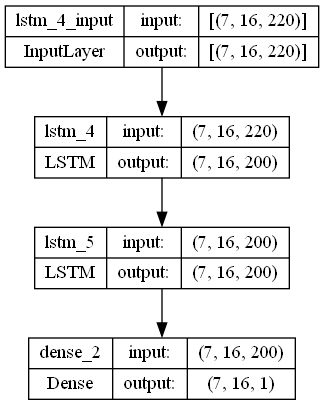

In [20]:
batch_size = 16
tf_input = ([batch_size, input_size])

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units[0], input_shape=tf_input, batch_size=7, time_major=True, return_sequences=True),
    tf.keras.layers.LSTM(units[1], return_sequences=True, time_major=True),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])

lstm_model.summary()
tf.keras.utils.plot_model(lstm_model, 'modelLS.png', show_shapes=True)

In [21]:
metrics=['accuracy', 
    TP(name='TP'),
    FP(name='FP'),
    FN(name='FN'),
    TN(name='TN'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.TrueNegatives(name='tn')
   ]

# Compile graph

In [22]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# Tensorflow training parameters

In [23]:
steps_per_epoch = 50000
checkpoint_dir = "./checkpoints/ccf_220_keras_lstm_static/"
filepath = checkpoint_dir + "iter-{epoch:02d}/model.ckpt"
batch_size = 16

# Tensorflow training

In [ ]:
print ("Learning...")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_weights_only=True, verbose=1)
train_generate = gen_training_batch(tdf,mapper,train_indices,batch_size)
lstm_model.fit(train_generate, epochs=2, steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[cp_callback])

Learning...


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
Epoch 1/2
 1859/50000 [>.............................] - ETA: 23:19 - loss: 0.1558 - accuracy: 0.9471 - TP: 12777.0000 - FP: 410.0000 - FN: 2094.0000 - TN: 14463.0000 - tp: 40636.0000 - fp: 3018.0000 - fn: 8003.0000 - tn: 156551.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 3718/50000 [=>............................] - ETA: 33:35 - loss: 0.1296 - accuracy: 0.9555 - TP: 26386.0000 - FP: 742.0000 - FN: 3353.0000 - TN: 29007.0000 - tp: 83803.0000 - fp: 5034.0000 - fn: 13478.0000 - tn: 314101.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 5577/50000 [==>...........................] - ETA: 35:09 - loss: 0.1109 - accuracy: 0.9615 - TP: 40531.0000 - FP: 1036.0000 - FN: 4083.0000 - TN: 43582.0000 - tp: 128643.0000 - fp: 6757.0000 - fn: 17292.0000 - tn: 471932.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 7436/50000 [===>..........................] - ETA: 35:28 - loss: 0.0965 - accuracy: 0.9663 - TP: 54925.0000 - FP: 1304.0000 - FN: 4559.0000 - TN: 58188.0000 - tp: 174702.0000 - fp: 8228.0000 - fn: 19877.0000 - tn: 630025.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 9295/50000 [====>.........................] - ETA: 34:55 - loss: 0.0853 - accuracy: 0.9700 - TP: 69480.0000 - FP: 1499.0000 - FN: 4876.0000 - TN: 72865.0000 - tp: 221392.0000 - fp: 9376.0000 - fn: 21836.0000 - tn: 788436.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
11154/50000 [=====>........................] - ETA: 33:58 - loss: 0.0766 - accuracy: 0.9730 - TP: 84128.0000 - FP: 1673.0000 - FN: 5100.0000 - TN: 87563.0000 - tp: 268561.0000 - fp: 10440.0000 - fn: 23322.0000 - tn: 946925.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
13012/50000 [======>.......................] - ETA: 32:43 - loss: 0.0693 - accuracy: 0.9755 - TP: 98855.0000 - FP: 1803.0000 - FN: 5238.0000 - TN: 102296.0000 - tp: 316052.0000 - fp: 11229.0000 - fn: 24475.0000 - tn: 1105588.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
14872/50000 [=======>......................] - ETA: 31:22 - loss: 0.0635 - accuracy: 0.9775 - TP: 113616.0000 - FP: 1906.0000 - FN: 5360.0000 - TN: 117070.0000 - tp: 363761.0000 - fp: 11960.0000 - fn: 25463.0000 - tn: 1264480.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
16730/50000 [=========>....................] - ETA: 29:59 - loss: 0.0587 - accuracy: 0.9792 - TP: 128392.0000 - FP: 2002.0000 - FN: 5452.0000 - TN: 131834.0000 - tp: 411575.0000 - fp: 12619.0000 - fn: 26312.0000 - tn: 1423254.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
18589/50000 [==========>...................] - ETA: 28:28 - loss: 0.0545 - accuracy: 0.9807 - TP: 143195.0000 - FP: 2079.0000 - FN: 5517.0000 - TN: 146633.0000 - tp: 459488.0000 - fp: 13204.0000 - fn: 27044.0000 - tn: 1582232.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
20449/50000 [===========>..................] - ETA: 26:37 - loss: 0.0511 - accuracy: 0.9819 - TP: 157991.0000 - FP: 2166.0000 - FN: 5600.0000 - TN: 161427.0000 - tp: 507486.0000 - fp: 13733.0000 - fn: 27729.0000 - tn: 1741340.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
22307/50000 [============>.................] - ETA: 24:35 - loss: 0.0481 - accuracy: 0.9829 - TP: 172776.0000 - FP: 2245.0000 - FN: 5678.0000 - TN: 176213.0000 - tp: 555469.0000 - fp: 14220.0000 - fn: 28393.0000 - tn: 1900302.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
24167/50000 [=============>................] - ETA: 22:39 - loss: 0.0454 - accuracy: 0.9839 - TP: 187599.0000 - FP: 2307.0000 - FN: 5737.0000 - TN: 191029.0000 - tp: 603607.0000 - fp: 14703.0000 - fn: 28966.0000 - tn: 2059428.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
26025/50000 [==============>...............] - ETA: 20:44 - loss: 0.0431 - accuracy: 0.9847 - TP: 202400.0000 - FP: 2371.0000 - FN: 5798.0000 - TN: 205831.0000 - tp: 651676.0000 - fp: 15182.0000 - fn: 29533.0000 - tn: 2218409.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
27884/50000 [===============>..............] - ETA: 19:00 - loss: 0.0411 - accuracy: 0.9854 - TP: 217230.0000 - FP: 2420.0000 - FN: 5845.0000 - TN: 220649.0000 - tp: 699837.0000 - fp: 15602.0000 - fn: 30046.0000 - tn: 2377523.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
29743/50000 [================>.............] - ETA: 17:14 - loss: 0.0393 - accuracy: 0.9860 - TP: 232066.0000 - FP: 2466.0000 - FN: 5878.0000 - TN: 235478.0000 - tp: 748001.0000 - fp: 15999.0000 - fn: 30540.0000 - tn: 2536676.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
31602/50000 [=================>............] - ETA: 15:34 - loss: 0.0376 - accuracy: 0.9866 - TP: 246890.0000 - FP: 2515.0000 - FN: 5925.0000 - TN: 250302.0000 - tp: 796155.0000 - fp: 16403.0000 - fn: 31040.0000 - tn: 2695826.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
33462/50000 [===================>..........] - ETA: 13:55 - loss: 0.0361 - accuracy: 0.9871 - TP: 261735.0000 - FP: 2551.0000 - FN: 5957.0000 - TN: 265149.0000 - tp: 844390.0000 - fp: 16754.0000 - fn: 31477.0000 - tn: 2855123.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
35320/50000 [====================>.........] - ETA: 12:17 - loss: 0.0348 - accuracy: 0.9876 - TP: 276562.0000 - FP: 2595.0000 - FN: 5994.0000 - TN: 279969.0000 - tp: 892576.0000 - fp: 17107.0000 - fn: 31923.0000 - tn: 3014234.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
37180/50000 [=====================>........] - ETA: 10:41 - loss: 0.0336 - accuracy: 0.9880 - TP: 291416.0000 - FP: 2641.0000 - FN: 6024.0000 - TN: 294799.0000 - tp: 940786.0000 - fp: 17464.0000 - fn: 32379.0000 - tn: 3173531.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9780\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32


# Save model from checkpoint

In [ ]:
lstm_model.save_weights(os.path.join(save_dir,"wts"))
lstm_model.save(save_dir)

# Generator for validation/test batches

In [24]:
def gen_test_batch(df, mapper, indices, batch_size):
    rows = indices.shape[0]
    index_array = np.zeros((rows, seq_length), dtype=np.int)
    for i in range(seq_length):
        index_array[:,i] = indices + 1 - seq_length + i
    count = 0
    while (count + batch_size <= rows):        
        full_df = mapper.transform(df.loc[index_array[count:count+batch_size].flatten()])
        data = full_df.drop(['Is Fraud?'],axis=1).to_numpy().reshape(batch_size, seq_length, -1)
        targets = full_df['Is Fraud?'].to_numpy().reshape(batch_size, seq_length, 1)
        count += batch_size
        data_t = np.transpose(data, axes=(1,0,2))
        targets_t = np.transpose(targets, axes=(1,0,2))
        yield data_t, targets_t

# Tensorflow test

In [ ]:
batch_size = 2000

input_size=220
output_size=1
units=[200,200]

tf_input = ([batch_size, input_size])

new_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units[0], input_shape=tf_input, batch_size=7, time_major=True, return_sequences=True),
    tf.keras.layers.LSTM(units[1], return_sequences=True, time_major=True),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])
new_model.load_weights(os.path.join(save_dir,"wts"))
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
ddf = pd.read_csv('test_220_100k.csv', dtype={"Merchant Name":"str"}, index_col='Index')
indices = np.loadtxt('test_220_100k.indices')

batch_size = 2000

print("\nQuick test")
test_generate = gen_test_batch(ddf,mapper,indices,batch_size)
score = new_model.evaluate(test_generate, verbose=1)

# print("\nFull test")
# test_generate = gen_test_batch(tdf,mapper,test_indices,batch_size)
# new_model.evaluate(test_generate, verbose=1)

In [ ]:
def f1(conf):
    precision = float(conf[1][1]) / (conf[1][1]+conf[0][1])
    recall = float(conf[1][1]) / (conf[1][1]+conf[1][0])
    return 2 * precision * recall / (precision + recall)

In [ ]:
print(f1([[99867,15],[4,114]]))
print(f1([[4862490,1561],[328,5621]]))

In [ ]:
batch_size = 16
tf_input = ([batch_size, input_size])

new_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units[0], input_shape=tf_input, batch_size=7, time_major=True, return_sequences=True),
    tf.keras.layers.LSTM(units[1], return_sequences=True, time_major=True),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])
new_model.load_weights(os.path.join(save_dir,"wts"))
new_model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
new_model.summary()
tf.keras.utils.plot_model(new_model, 'model.png', show_shapes=True, expand_nested=True)

## Convert to ONNX

In [ ]:
from tensorflow import keras
import keras2onnx
import onnx

# convert to onnx
onnx_model = keras2onnx.convert_keras(new_model, new_model.name)

# Save
onnx.save_model(onnx_model, "ccf_lstm_static_keras2onnx.onnx")

In [ ]:
import tf2onnx

# convert to onnx
spec = (tf.TensorSpec((7, 16, 220), tf.float32, name="input"),)
output_path = new_model.name + ".onnx"

onnx_model = tf2onnx.convert.from_keras(new_model, spec, output_path=output_path)